In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/villarreal/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
MIN_MINUTES = 800

VILLARREAL_COLORS = {
    'primary': '#FFE500',
    'secondary': '#005187'
}

MINNESOTA_COLORS = {
    'primary': '#8CD2F4',
    'secondary': '#231F20'
}

FW_PLAYERS = [
    {'name': 'Thierno Barry', 'search': 'Barry', 'pos': 'FW', 'team': 'Villarreal'},
    {'name': 'Tani Oluwaseyi', 'search': 'Oluwaseyi', 'pos': 'FW', 'team': 'Minnesota'},
]

SAVE_PATH_BASE = "./barry_oluwaseyi_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD - Combinar Big 5 + MLS
db = get_db_manager()

big5_leagues = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
league_list_str = "', '".join(big5_leagues)

# Query Big 5 (season 2425)
query_big5 = text(f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic p
WHERE p.league IN ('{league_list_str}')
AND p.season = '2425'
ORDER BY p.league, p.season DESC, p.team, p.player_name
""")

# Query MLS (season 2025)
query_mls = text("""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    NULL::jsonb as understat_metrics
FROM footballdecoded.players_extras p
WHERE p.league = 'USA-MLS'
AND p.season = '2025'
ORDER BY p.team, p.player_name
""")

try:
    with db.engine.begin() as conn:
        df_big5 = pd.read_sql(query_big5, conn)
        df_mls = pd.read_sql(query_mls, conn)
    
    df_raw = pd.concat([df_big5, df_mls], ignore_index=True)
    
    print(f"Big 5 (2425): {len(df_big5)} | MLS (2025): {len(df_mls)} | Total: {df_raw.shape[0]} registros")
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
finally:
    db.close()

df_raw.head()

2025-12-31 08:32:07,700 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev


2025-12-31 08:32:07,845 - database.connection - INFO - Database connection successful


Big 5 (2425): 2722 | MLS (2025): 850 | Total: 3572 registros


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4e7d1dd4e449b118,Ross Barkley,Aston Villa,ENG-Premier League,2425,MF,ENG,30.0,"{'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '3',...","{'understat_xa': '0.9665419245138764', 'unders..."
1,40fa60b57ca0dd78,Tyrone Mings,Aston Villa,ENG-Premier League,2425,DF,ENG,31.0,"{'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '11'...","{'understat_xa': '0.17970541678369045', 'under..."
2,b38d0a69872aad15,Youri Tielemans,Aston Villa,ENG-Premier League,2425,MF,BEL,27.0,"{'FK': '0', 'OG': '0', 'Crs': '119', 'Fld': '5...","{'understat_xa': '8.044237377122045', 'underst..."
3,32745a88508ff555,Adam Smith,Bournemouth,ENG-Premier League,2425,DF,ENG,33.0,"{'FK': '0', 'OG': '0', 'Crs': '33', 'Fld': '12...","{'understat_xa': '0.4430896267294884', 'unders..."
4,ed7d2a945e5f868a,Alex Scott,Bournemouth,ENG-Premier League,2425,MF,ENG,20.0,"{'CS': '0', 'FK': '1', 'OG': '0', '/90': '-0.2...","{'understat_xa': '1.2158988821320236', 'unders..."


In [4]:
# Filtrar por minutos mínimos Y posición FW
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('FW', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + FW: {df_filtered.shape[0]} jugadores")

Filtro 800+ min + FW: 660 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [6]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [7]:
# Métricas a excluir de normalización
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duals_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id', 
    'CS%', 'CS', 'PSxG+/-', 'PSxG', 'Save_Save%',
    "Sweeper_#OPA", 'Sweeper_#OPA/90', 'Sweeper_AvgDist', "Goal Kicks_Launch%", 'G-xG'
}

# Calcular per100touches FBref
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

# Calcular per100touches Understat
understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per100, understat_per100], axis=1)

Per100touches: 145 + 7


In [8]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 347
Percentiles totales: 347


In [9]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 660 filas, 700 columnas
Limpieza completada: 698 columnas finales


In [10]:
# Search FW players
player_ids = {}

print("FORWARD PLAYER SEARCH:")
print("=" * 50)

for player_config in FW_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
    ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}':")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                break
    else:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

if len(player_ids) == 2:
    print(f"\n✓ ALL PLAYERS FOUND")
else:
    print(f"\n✗ MISSING PLAYERS")

FORWARD PLAYER SEARCH:

Thierno Barry - search: 'Barry':
  260b2b815532355b - Thierno Barry (Villarreal, ESP-La Liga, FW) - 2323.0 min
  ✓ ASSIGNED: Thierno Barry -> 260b2b815532355b

Tani Oluwaseyi - search: 'Oluwaseyi':
  8aeb68b1091ff9ae - Tani Oluwaseyi (Minnesota Utd, USA-MLS, FW,MF) - 1856.0 min
  ✓ ASSIGNED: Tani Oluwaseyi -> 8aeb68b1091ff9ae

PLAYERS FOUND:
  Thierno Barry: 260b2b815532355b
  Tani Oluwaseyi: 8aeb68b1091ff9ae

✓ ALL PLAYERS FOUND


In [11]:
# FW Centro metrics configuration
fw_metrics = [
    'expected_goals_per100touches', 'goals_per100touches', 'shots_per100touches', 'Touches_Att Pen_per100touches',
    'expected_assists_per100touches', 'Take-Ons_Succ_per100touches', 'npxG/Sh', 'G-xG',
    'Fld_per100touches', 'SCA_SCA90'
]
fw_titles = [
    'Expected Goals', 'Goals', 'Shots', 'Touches in Box',
    'Expected Assists', 'Dribbles', 'npxG per Shot', 'Goals - xG',
    'Fouls Drawn', 'Shot Creating Actions'
]

METRICS_BY_POSITION = {
    'fw_st': {'metrics': fw_metrics, 'titles': fw_titles}
}

print("FW METRICS VERIFICATION:")
print("=" * 50)
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

FW METRICS VERIFICATION:
OK fw_st: 10 metrics, 10 titles


In [12]:
# Barry vs Oluwaseyi comparison configuration
COMPARISON = {
    'name': 'Barry_vs_Oluwaseyi',
    'player1': 'Thierno Barry',
    'player2': 'Tani Oluwaseyi', 
    'position_type': 'FW_ST',
    'metrics_key': 'fw_st',
    'title': 'Thierno Barry vs Tani Oluwaseyi (24/25)',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/barry.png', '/home/jaime/FD/data/blog/caras/tfm/oluwaseyi.png'],
    'colors': [VILLARREAL_COLORS['primary'], MINNESOTA_COLORS['primary']]
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"\nMETRICS BY POSITION:")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

COMPARISON: Thierno Barry vs Tani Oluwaseyi (24/25)

METRICS BY POSITION:
OK fw_st: 10 metrics, 10 titles


FW/ST PLAYER RADAR GENERATION

Processing: Thierno Barry vs Tani Oluwaseyi (24/25)
  Dataset: 660 players (FW)
  Teams: Villarreal vs Minnesota Utd
  Colors: ['#FFE500', '#8CD2F4']


  ✓ Completed: Barry_vs_Oluwaseyi_combined.png


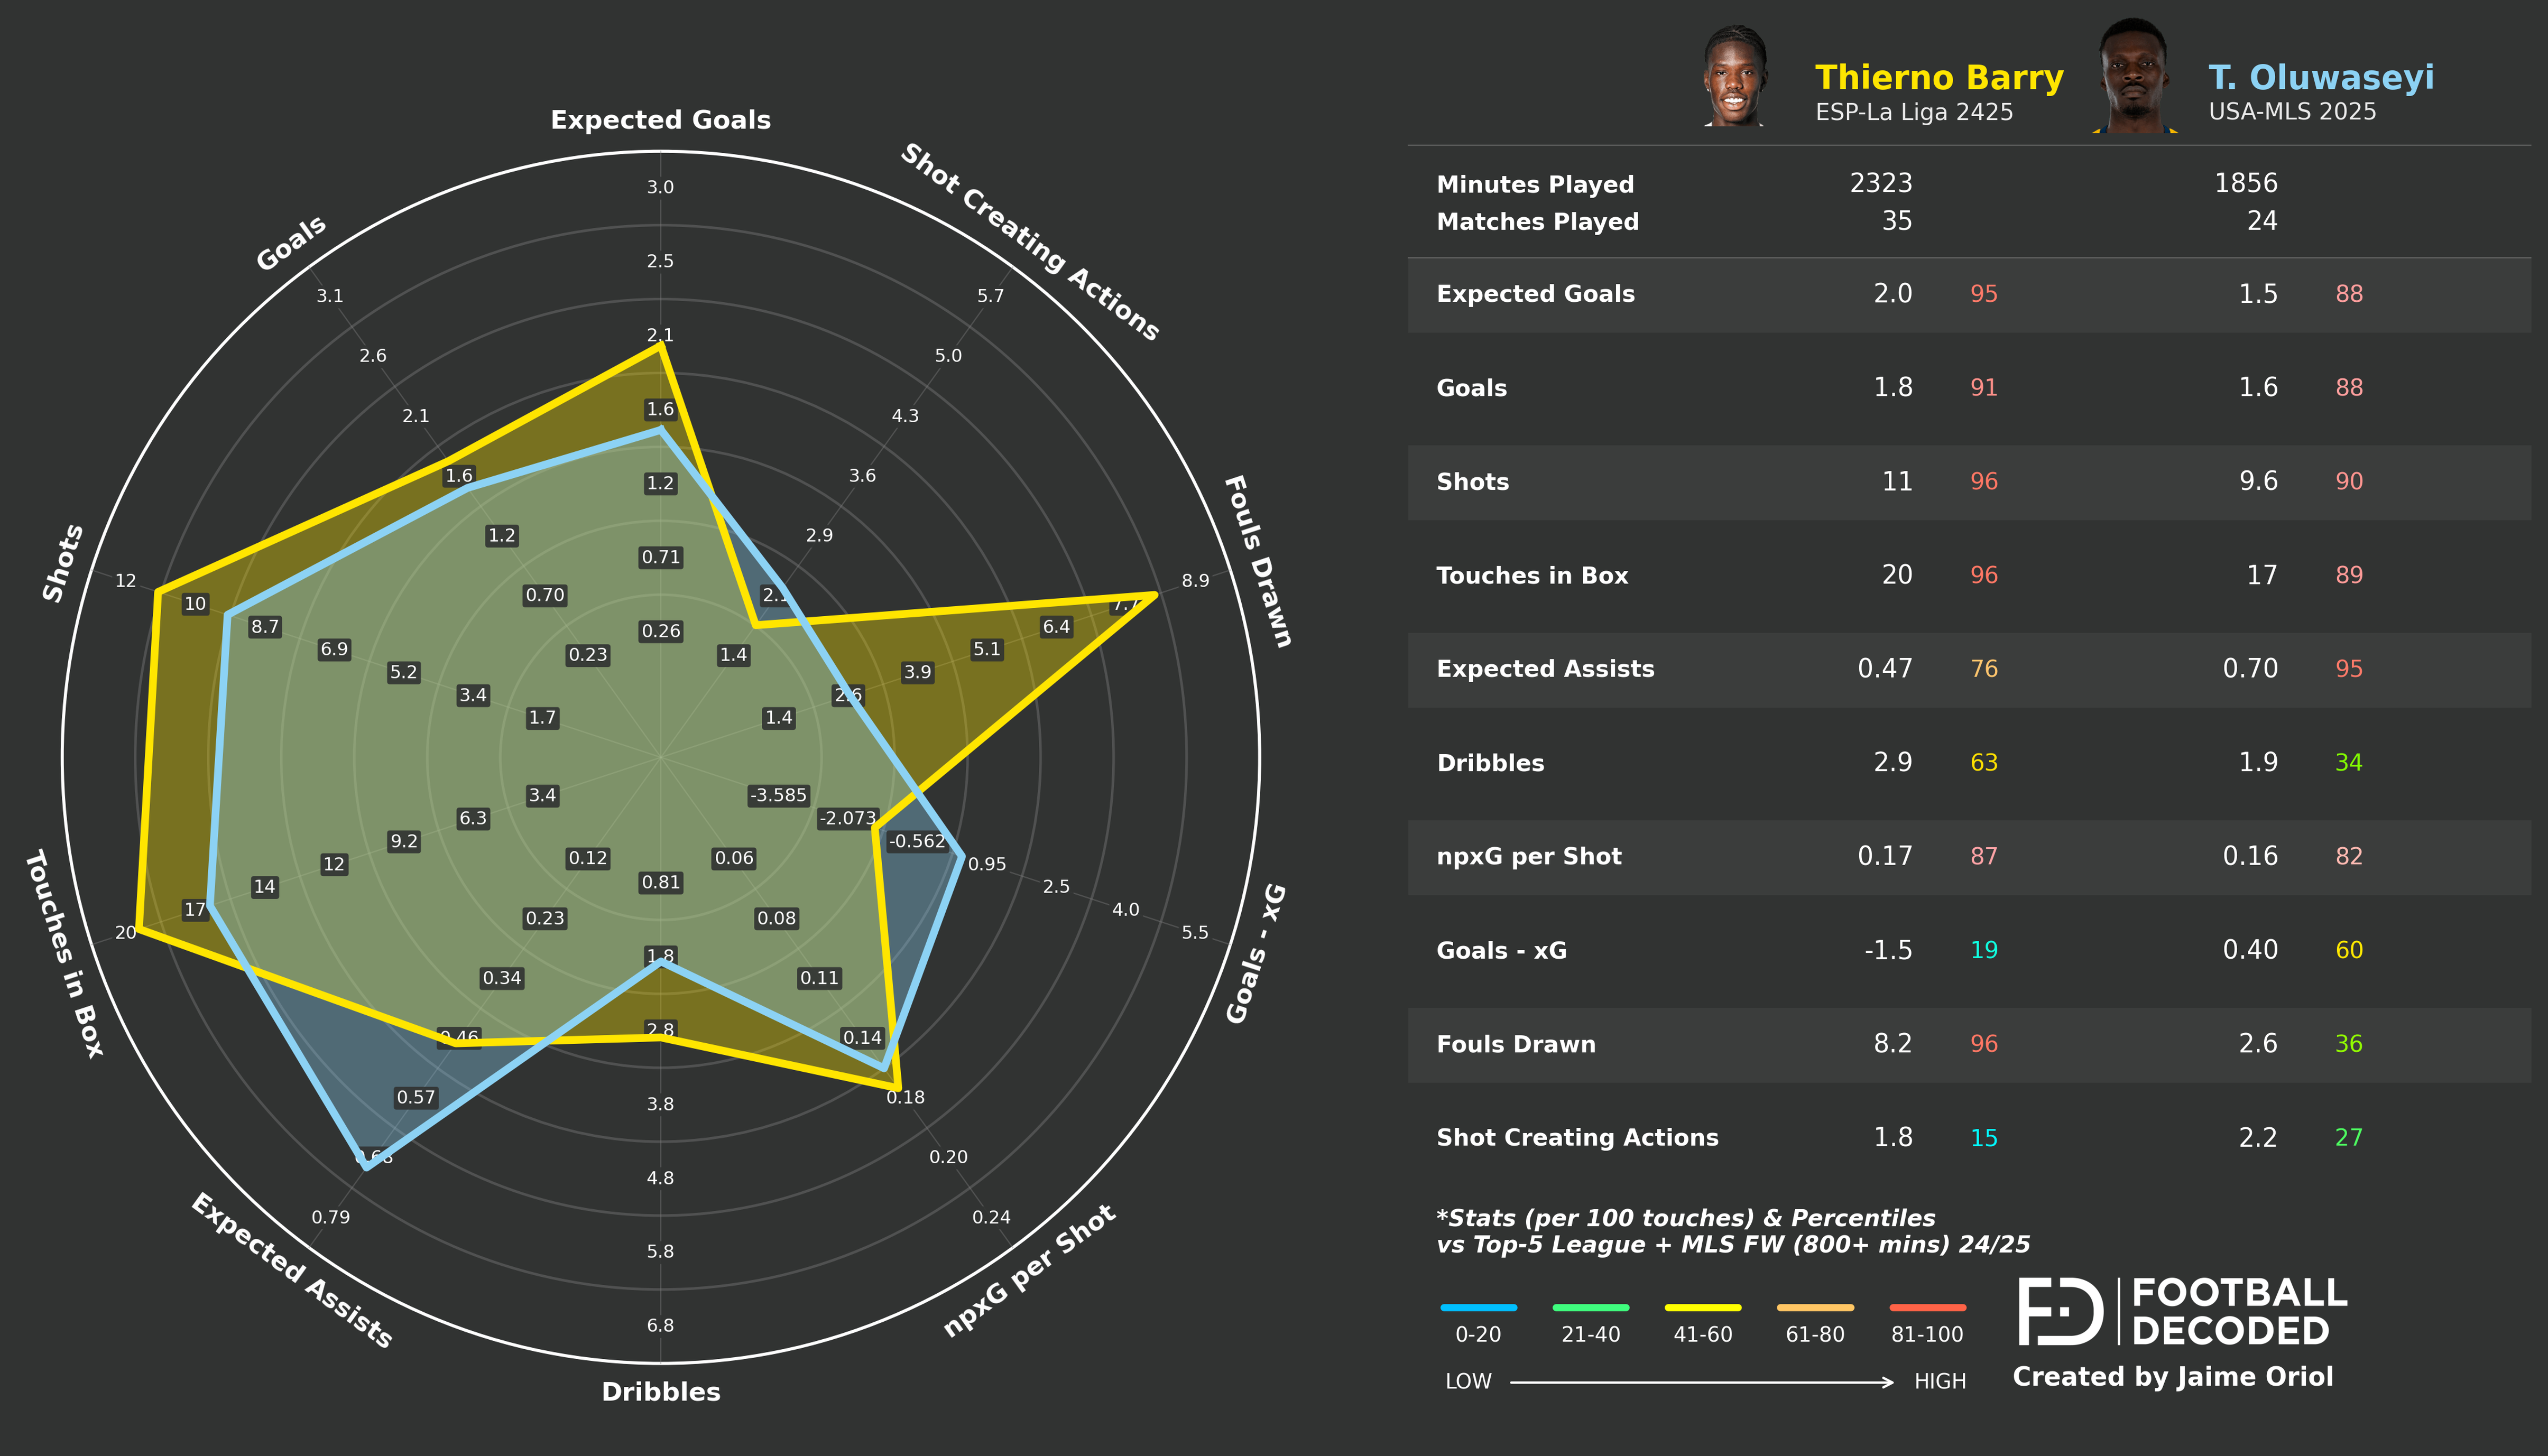


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./barry_oluwaseyi_radars/


In [13]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("FW/ST PLAYER RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset FW
    position_df = df_final[df_final['position'].str.contains('FW', case=False, na=False)].copy()
    position_filter = "FW"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 100 touches) & Percentiles\nvs Top-5 League + MLS {position_filter} ({MIN_MINUTES}+ mins) 24/25",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()